In [1]:
# Initial setup of copula generative model based on parametric distributions for larger set of variables
#
# Author: Alex Braafladt
#
# Version: v1 Initial creation 3/11/2022
#          v2 First draft with all components for nonparametric experiment for continuous case 3/14/2022
#          v3 Draft with updates for hosting on GitHub 4/30/2022
#
# References:
#   -https://openturns.github.io/openturns/latest/theory/probabilistic_modeling/copulas.html#copula
#   -https://openturns.github.io/openturns/latest/auto_probabilistic_modeling/copulas/plot_composed_copula.html
#   -https://en.wikipedia.org/wiki/Copula_(probability_theory)

# Nonparametric Order Reduction Using Canonical Problem
This notebook examines the ability to unsupervised learning - order reduction - techniques to find a data-based basis of reduced dimensionality for the data generated using the marginal+copula joint distribution, generative model that was set up to match the characteristics of the distributions expected in the outputs from agent-based simulation

In [2]:
# probabilistic and statistical modeling
import openturns as ot
import openturns.viewer as viewer
from statsmodels.distributions.empirical_distribution import ECDF
from scipy import stats as st
from scipy.stats import pearsonr
from scipy.spatial.distance import jensenshannon

# data and numerical functions
import numpy as np
import pandas as pd

# graphing and visualization functions
import matplotlib.pyplot as plt
import seaborn as sns

# order reduction and data conditioners
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.model_selection import train_test_split

# design of experiments
from doepy import build

# os operations
import os as os
import sys
import datetime as dt
import pickle
from joblib import dump, load

# custom functions
import stats_functions as sf
import copula_gen_data as cpgen
from emulator_classes import Simulation, Data

In [3]:
# directory setup

# get current working directory
wrkdir = os.getcwd()
print('Current working directory: '+wrkdir)
# set up a data save directory for all future runs
newoutputdir = wrkdir+'\output'
if not os.path.exists(newoutputdir):
    os.makedirs(newoutputdir)
# set up a new directory to store files for the current run - updates at each new full run of notebook
curDatetime = dt.datetime.now()
datasavedir = newoutputdir + r'\\' + 'nonparOR' + str(curDatetime.strftime('%Y%m%d%H%M%S'))
if not os.path.exists(datasavedir):
    os.makedirs(datasavedir)
print('Data save directory: '+datasavedir)

Current working directory: C:\Users\alexb\PycharmProjects\distribution-surrogates
Data save directory: C:\Users\alexb\PycharmProjects\distribution-surrogates\output\\nonparOR20220504173724


#### Marginal distributions
The simulation emulator used here involves 30 marginal distributions connected through a Gaussian copula that defines the correlations between the marginals randomly. The marginal distributions' pdfs are plotted below.

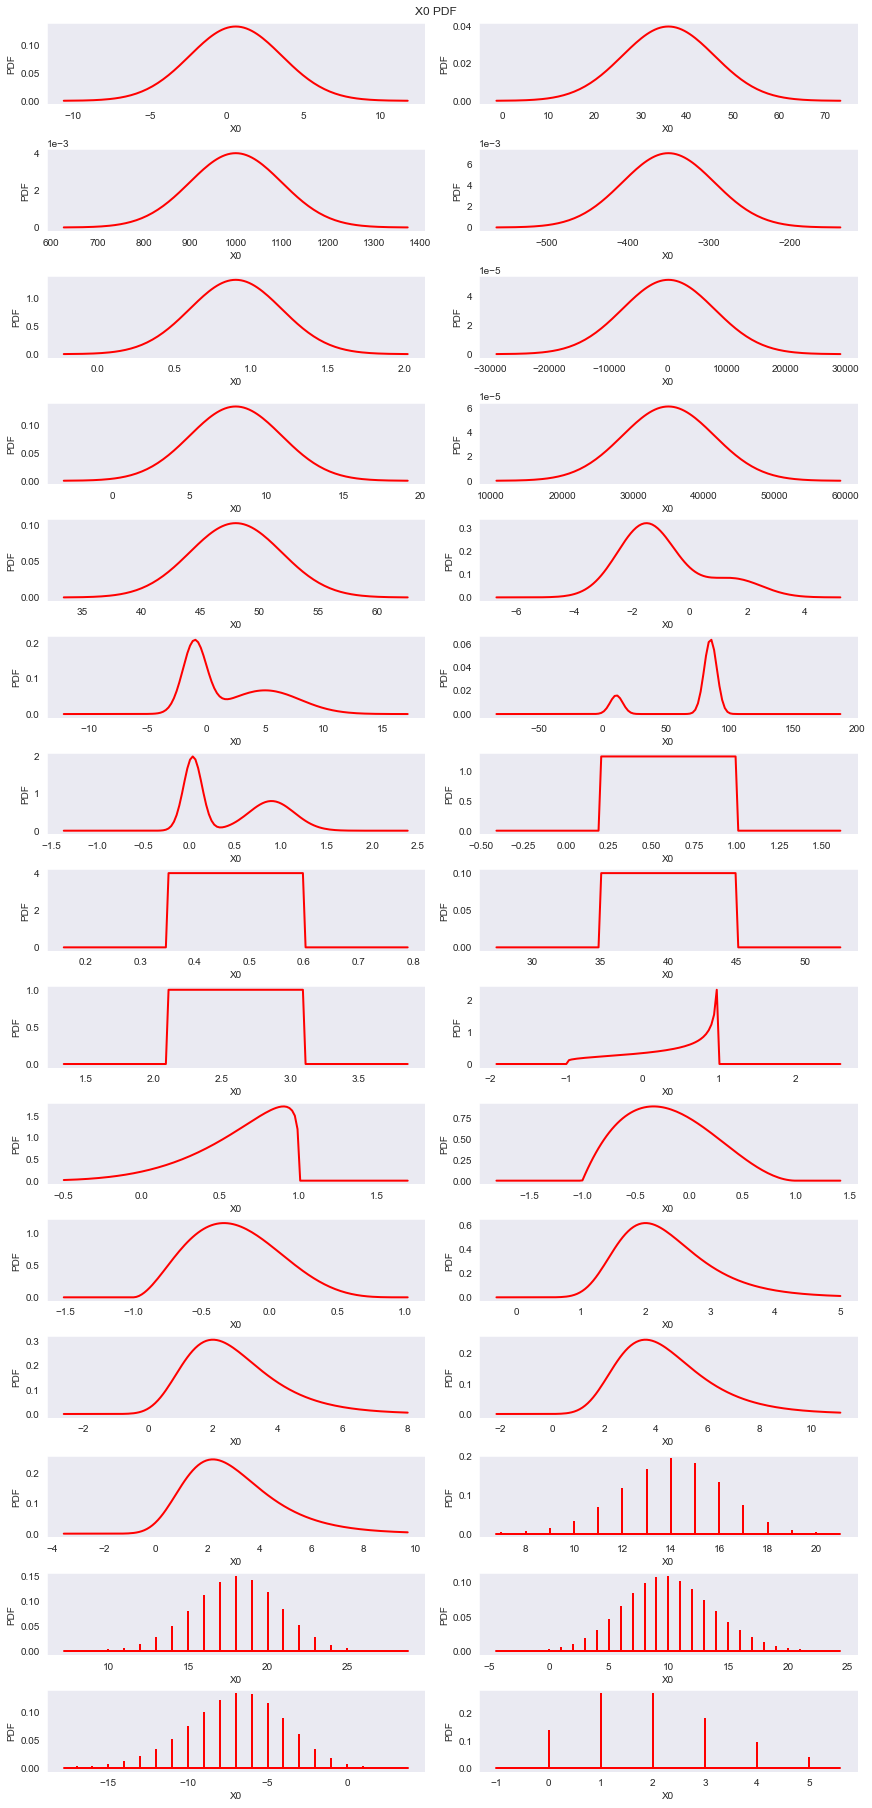

In [4]:
# generate data for non-parametric OR experiment
x_in = np.array([1000., 6500., -1.0, 0.2, 0.2, 45., 1.2, 3.0, 0.6, 2.2, 0.7, 0.6, 12., 8., 2.])
single_sim = Simulation(x_in, 42)
sample_set = single_sim.get_joint_distribution_samples(1000)
dists = single_sim.marginals

# plot the true marginal distributions
fig1, ax1 = plt.subplots(15, 2, figsize=(12,25), constrained_layout=True)
ax = ax1.ravel()
for i in range(0,len(dists)):
    pdfdraw = dists[i].drawPDF()
    pdfview = ot.viewer.View(pdfdraw,axes=ax[i:])
    ax[i].get_legend().remove()
    ax[i].grid(visible=False)

In [5]:
# flag which distributions are discrete for later use in analysis
discrete_flags = []
for i in range(25):
    discrete_flags.append(False)
for i in range(5):
    discrete_flags.append(True)

# generate samples from the joint distribution
data = Data(samples=np.expand_dims(sample_set, axis=0), discrete_flags=discrete_flags)
data.data_setup_from_samples()

#### Sampling the stochastic distributions
Samples generated with traditional Monte Carlo simulation are drawn from the joint distribution and shown below in histograms.

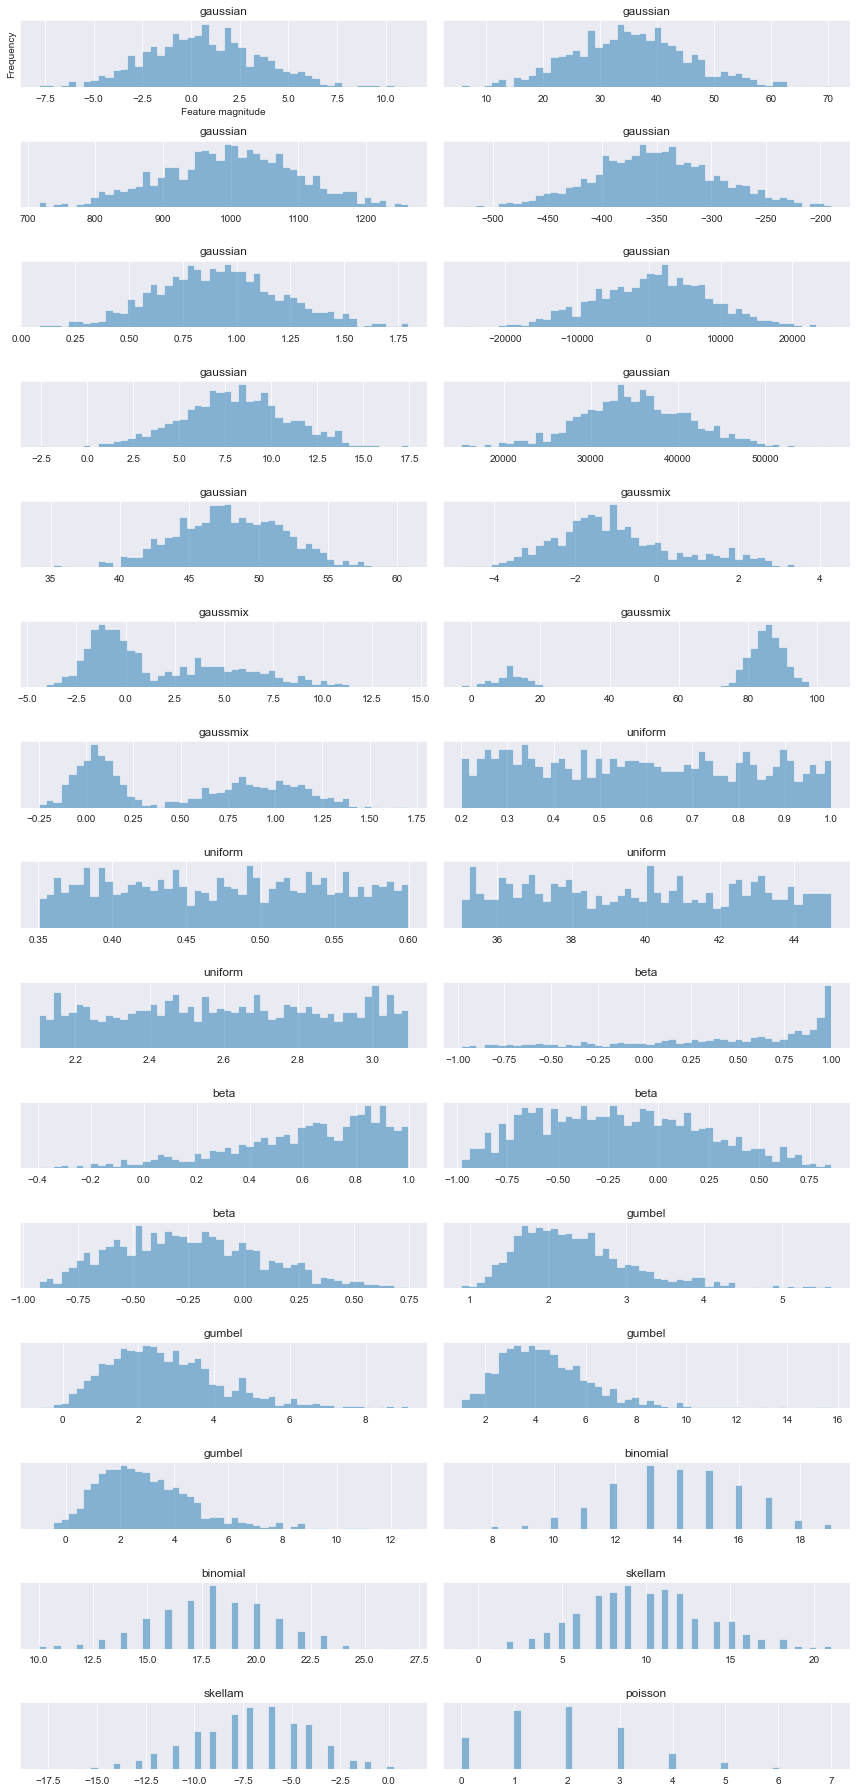

In [6]:
# take a look at plots of the samples (without scaling)
fig2, ax2 = plt.subplots(15, 2, figsize=(12,25))
ax = ax2.ravel()
for i in range(data.samples.shape[2]):
    _, bins = np.histogram(data.samples[0,:,i], bins=50)
    ax[i].hist(data.samples[0,:,i], bins=bins, alpha=0.5, histtype='stepfilled')
    ax[i].set_title(single_sim.distribution_types[i])
    ax[i].set_yticks(())
ax[0].set_xlabel("Feature magnitude")
ax[0].set_ylabel("Frequency")
fig2.tight_layout()
# fig2.savefig('FullDistSamples.png', format='png')

#### Scaling
The standard scaler from the scikit-learn package is used to scale the data to prepare it for effective learning

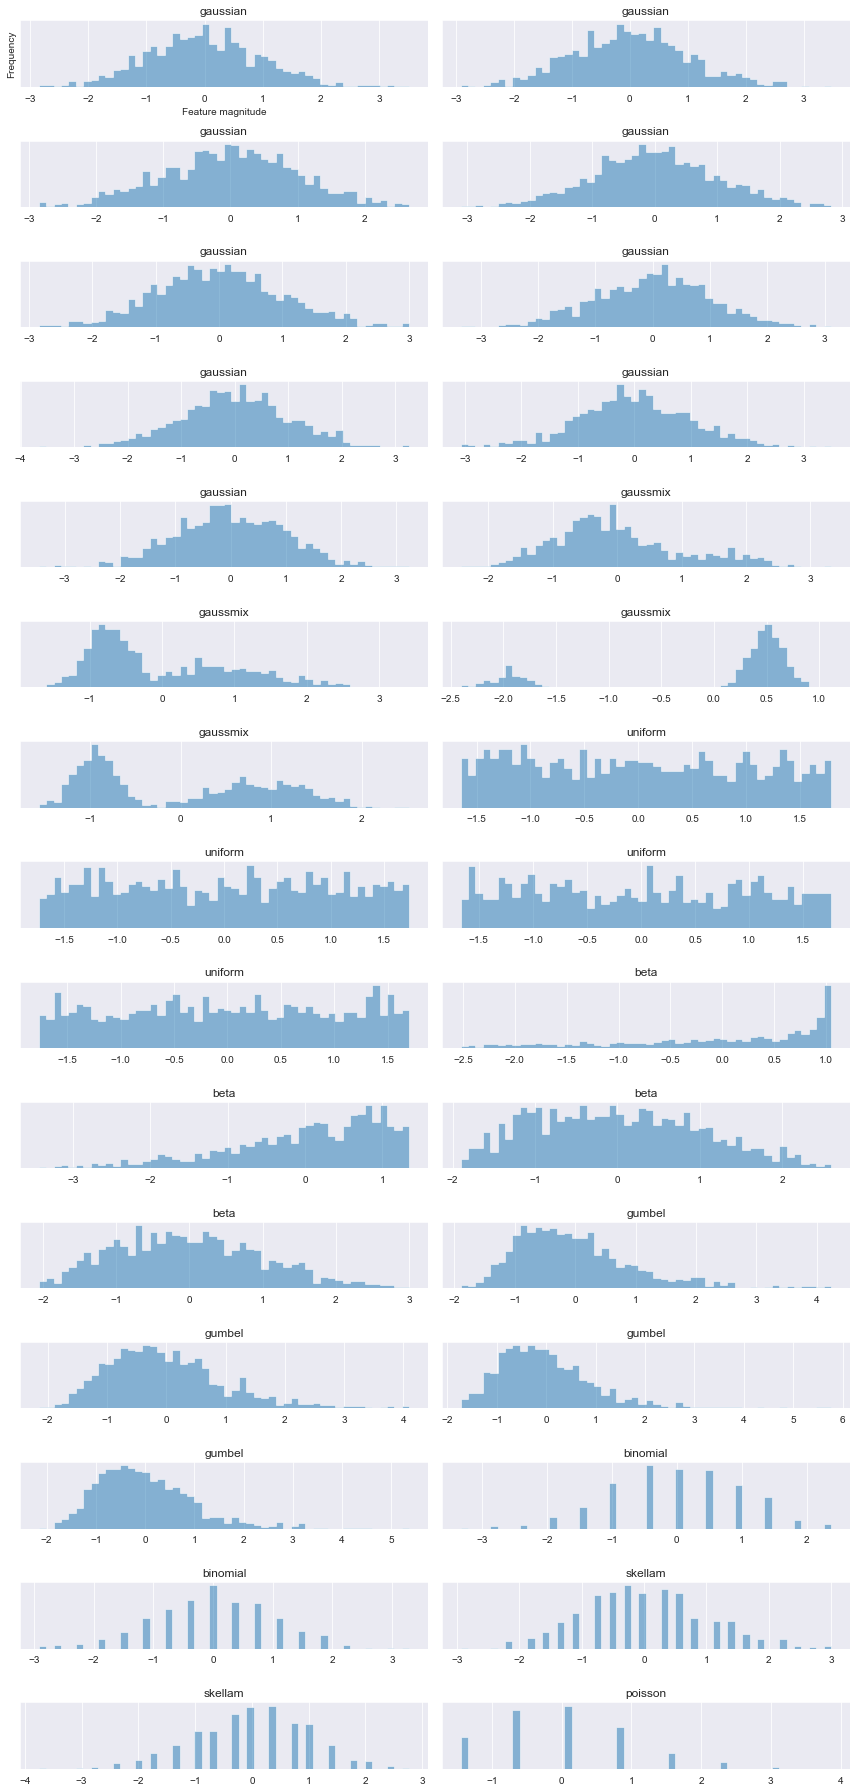

In [7]:
# take a look at plots of the samples (with scaling)
fig3, ax3 = plt.subplots(15, 2, figsize=(12,25))
ax = ax3.ravel()
for i in range(data.scaled_samples.shape[2]):
    _, bins = np.histogram(data.scaled_samples[0,:,i], bins=50)
    ax[i].hist(data.scaled_samples[0,:,i], bins=bins, alpha=0.5, histtype='stepfilled')
    ax[i].set_title(single_sim.distribution_types[i])
    ax[i].set_yticks(())
ax[0].set_xlabel("Feature magnitude")
ax[0].set_ylabel("Frequency")
fig3.tight_layout()

#### Correlations
Key to being able to effectively find a reduced order basis is the correlation between the marginal distributions, defined here using a Gaussian copula approach, which is confirmed using the pearson r test from scipy stats.

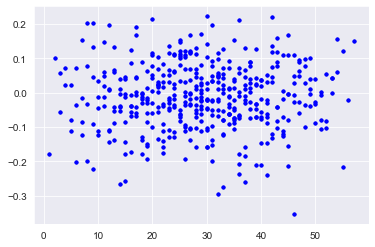

In [8]:
# check the correlation in the dataset
fig3, ax3 = plt.subplots(1,1)
for i in range(0, data.scaled_samples.shape[2]):
    for j in range(0,data.scaled_samples.shape[2]):
        corr_test = pearsonr(data.scaled_samples[0,:,i], data.scaled_samples[0,:,j])
        #print('Feature ', i, ' compared to ', j, 'stat: %.3f, pval: %.3f' % (corr_test[0], corr_test[1]))
        if i != j:
            plt.scatter(i+j,corr_test[0],marker='.',c='b')

#### Order reduction
Having established the simulation emulator, and the distributions generated - 30 correlated marginals with a variety of parametric forms - the order reduction process involves unsupervised learning to determine the reduced basis. In this case, principal components analysis (PCA) is used to find a linear reduced basis directly between the distributions.

In [9]:
# test PCA approach

# first directly with samples
data_pca = data.scaled_samples[0]
req_ric = 0.99
pca = PCA(req_ric)
pca.fit(data_pca)
print('Number of components needed for retaining ', req_ric, ' RIC: ', pca.n_components_)
X_pca = pca.transform(data_pca)
print("Original shape: {}".format(str(data_pca.shape)))
print("Reduced shape: {}".format(str(X_pca.shape)))
X_pca_plot = pd.DataFrame(X_pca)

Number of components needed for retaining  0.99  RIC:  28
Original shape: (1000, 30)
Reduced shape: (1000, 28)


#### Unstructured samples
Order reduction on the unstructured samples results with a requirement for retaining 99% of the variance of the data results in only a small reduction in the basis required. The latent space is shown below.

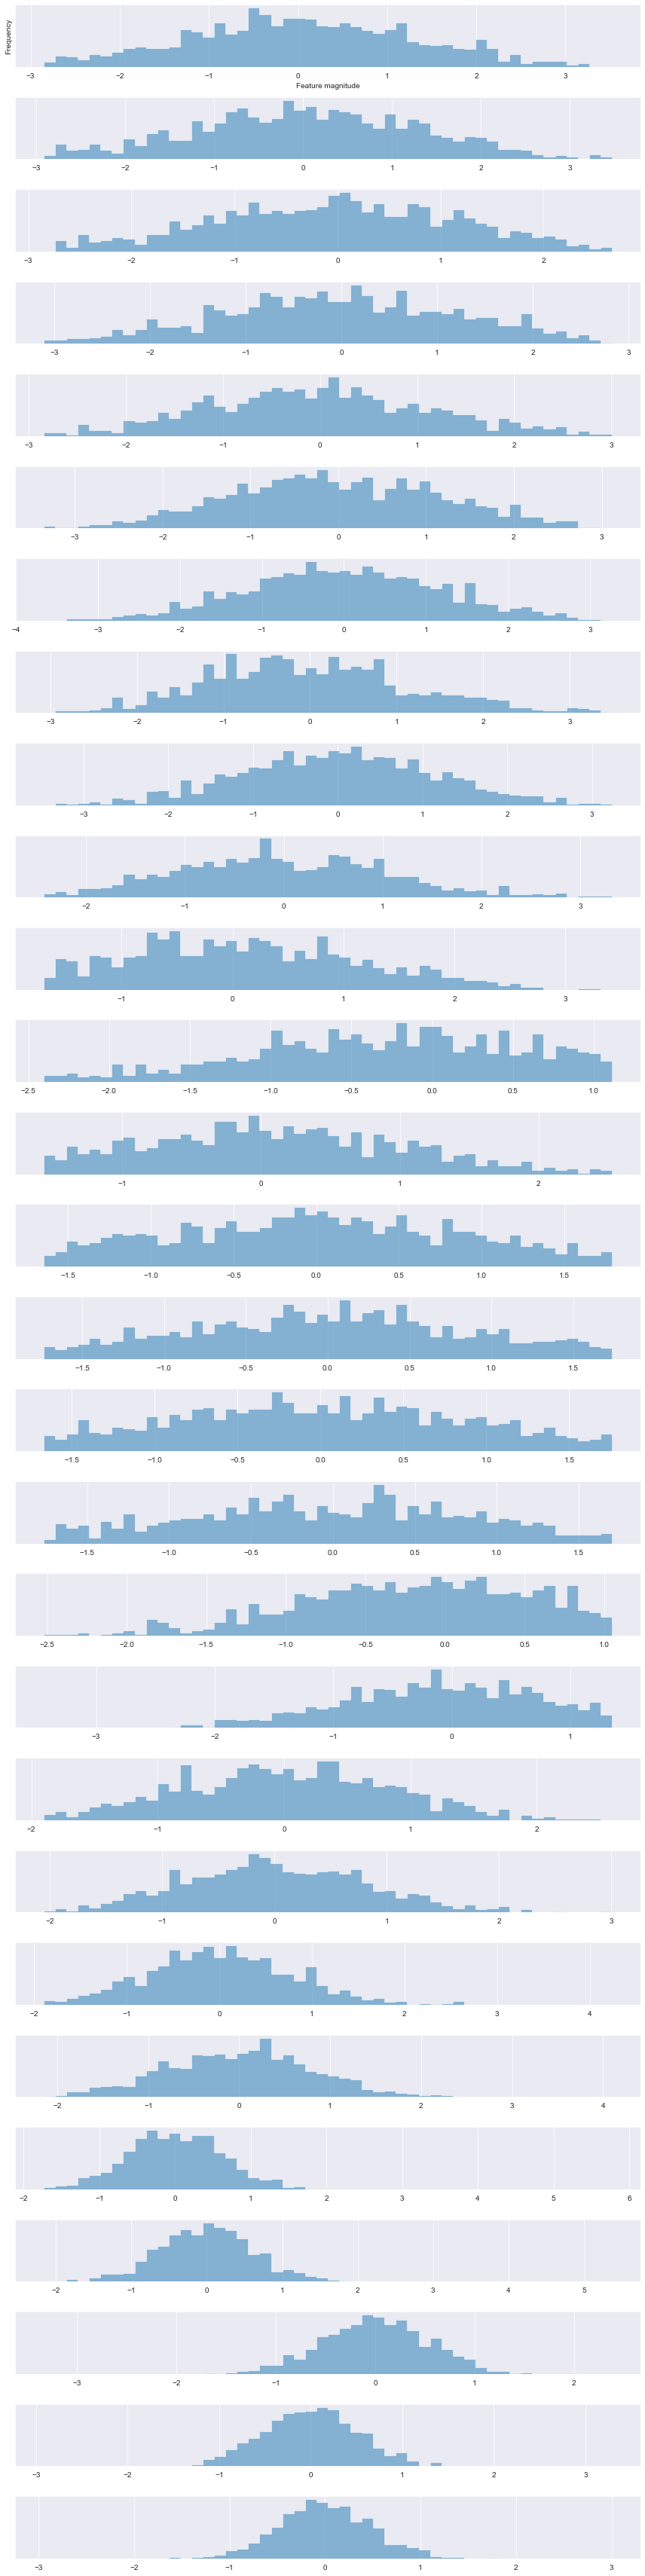

In [10]:
# plotting latent space data
# plotting scaled data
fig4, ax4 = plt.subplots(pca.n_components_, 1, figsize=(12,1.7*pca.n_components_))
ax = ax4.ravel()
for i in range(pca.n_components_):
    # use original bins
    _, bins = np.histogram(data_pca[:, i], bins=50)
    ax[i].hist(X_pca_plot.iloc[:, i], bins=bins, alpha=0.5, histtype='stepfilled')
    ax[i].set_yticks(())
ax[0].set_xlabel("Feature magnitude")
ax[0].set_ylabel("Frequency")
fig4.tight_layout()

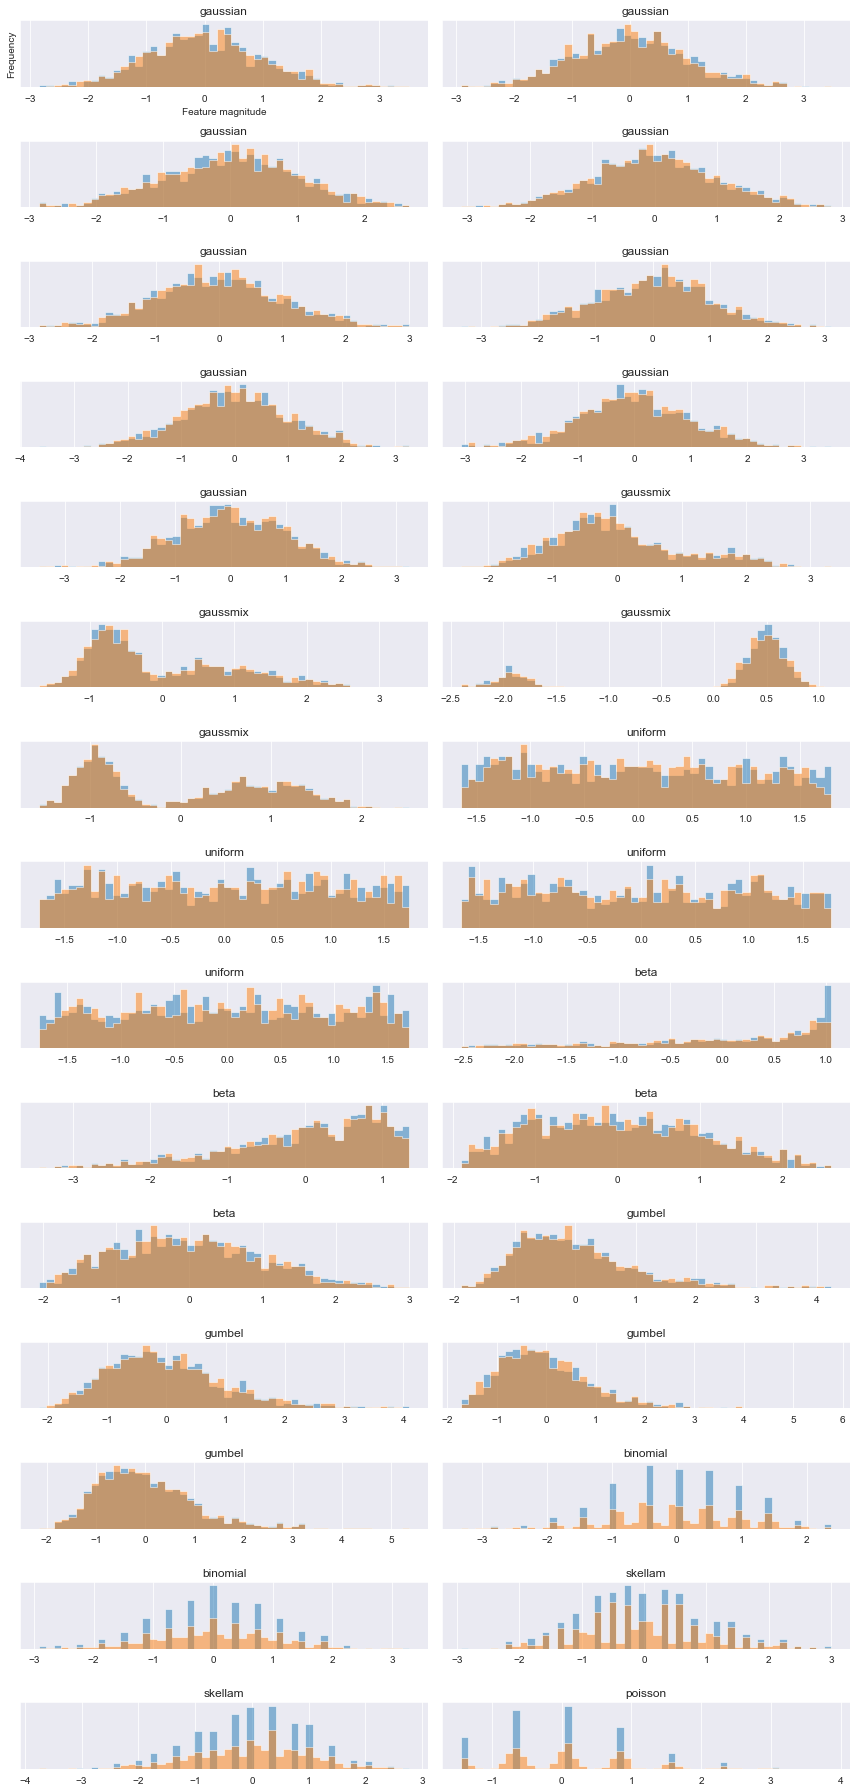

In [11]:
# plot a comparison between the true and approximated samples

# true distribution samples
X_plot_true = data_pca
# approximation with order reduction
X_pca_approx = pca.inverse_transform(X_pca)
# X_kpca_approx = kernel_pca.inverse_transform(X_kpca)

X_plot_approx = X_pca_approx

# take a look at plots of the samples (without scaling)
fig7, ax7 = plt.subplots(15, 2, figsize=(12,25))
ax = ax7.ravel()
for i in range(data_pca.shape[1]):
    _, bins = np.histogram(data_pca[:, i], bins=50)
    ax[i].hist(X_plot_true[:, i], bins=bins, alpha=0.5, histtype='stepfilled')
    ax[i].hist(X_plot_approx[:, i], bins=bins, alpha=0.5, histtype='stepfilled')
    ax[i].set_title(single_sim.distribution_types[i])
    ax[i].set_yticks(())
ax[0].set_xlabel("Feature magnitude")
ax[0].set_ylabel("Frequency")
fig7.tight_layout()

# note that rounding not included here to re-discretize the samples from the discrete distributions -
# will be set up and used later in the experiment however.

#### Statistical consistency
In addition to pure data-based comparison, the statistical consistency is compared using a set of statistical tests to enable observations about the quality of the approximation of the statistical character of the distributions.

In [12]:
# helper functions for creating epdfs

# set up an empirical probability mass/density function as a probability array
def epdf(samp, n=22, density=True):
    if density is True:
        h, e = np.histogram(samp, bins=n, density=density)
        p = h
    else:
        h, e = np.histogram(samp, bins=n, density=density)
        p = h / sum(h)
    return e, p

# enforce properties of probability arrays needed to calculate KL and JS metrics
def support_intersection(p, q):
    sup_int = (
        list(
            filter(
                lambda x: (x[0]!=0) & (x[1]!=0), zip(p, q)
            )
        )
    )
    return sup_int

# separate tuple into two arrays
def get_probs(list_of_tuples):
    p = np.array([p[0] for p in list_of_tuples])
    q = np.array([p[1] for p in list_of_tuples])
    return p, q

# condition data arrays and use scipy JS distance function
def compute_js_dist(p, q):
    """Take as input p and q as epdfs with the same edge values
    # check for and discard inconsistent data based on zeros"""
    temp = support_intersection(p,q)
    pn, qn = get_probs(temp)
    return jensenshannon(pn, qn)

# condition data arrays and use scipy KL divergence function - via entropy
def compute_kl_dist(p, q):
    temp = support_intersection(p,q)
    pn, qn = get_probs(temp)
    return st.entropy(pn, qn)

#### Structured order reduction
A main portion of the hypothesis covered in this experiment has to do with structuring the data to effectively reduce the order. The initial hypothesis is that structuring using histograms or "empirical probability density functions" will be feasible.

In [13]:
# structured data case

# initial data
x_true = data_pca
x_approx = X_pca_approx

# calculate epdfs to structure data
# holders
x_t_epdfs = []
x_a_epdfs = []
x_t_ecdfs = []
x_a_ecdfs = []
epdf_bins = []

# calculate
for i in range(0,x_true.shape[1]):
    _, bins = np.histogram(x_true[:, i], bins=50)
    epdf_bins.append(bins)
    x_t_ecdfs.append(ECDF(x_true[:,i]))
    x_a_ecdfs.append(ECDF(x_approx[:,i]))
    _, t_probs = epdf(x_true[:,i],n=bins)
    x_t_epdfs.append(t_probs)
    _, a_probs = epdf(x_approx[:,i],n=bins)
    x_a_epdfs.append(a_probs)

In [14]:
# now building new approx using structured data

# structured dataset
x_s_epdf = np.array(x_t_epdfs).T

# reducing structured dataset
req_ric = 0.99
pca_s = PCA(req_ric)

pca_s.fit(x_s_epdf)
print("number of components needed for retaining RIC: ", req_ric, " is ", pca_s.n_components_)

number of components needed for retaining RIC:  0.99  is  15


#### Structured OR results
structuring the data results in a significant reduction in the required basis for retaining a given information content of the data

In [15]:
# Now compare approximated data to initial data

print("Original shape: {}".format(str(x_s_epdf.shape)))
# get latent space
x_s_lat = pca_s.transform(x_s_epdf)
print("Latent shape: {}".format(str(x_s_lat.shape)))

# get approx data
x_s_approx_raw = pca_s.inverse_transform(x_s_lat)
print("Approximation shape: {}".format(str(x_s_approx_raw.shape)))

# post-process approx data to maintain statistical distirbution conditions
# (integral over array =1 and f(x)>0)
# enforce positive
x_s_approx = x_s_approx_raw
x_s_approx[x_s_approx < 0.0] = 0.
# normalize by sum of area of rectangles involved
bin_edges = epdf_bins
bin_heights = x_s_approx.T
np_bins = np.array(epdf_bins)
widths = np_bins[:,1:] - np_bins[:,:-1]
areas = np.multiply(widths,bin_heights)
area_sums = np.sum(areas, axis=1)
normed_bin_heights = bin_heights / area_sums[:,None]

# set the update for normalizing the epdfs
x_s_approx = normed_bin_heights.T

Original shape: (50, 30)
Latent shape: (50, 15)
Approximation shape: (50, 30)


#### Structured approximation comparison
The structured approximation is directly at the probability level of the histograms and with fixed bins from across the dataset, resulting in bar plots rather than direct histograms. Inspection of the figure below shows close agreement even with an approximately 50% reduction in order.

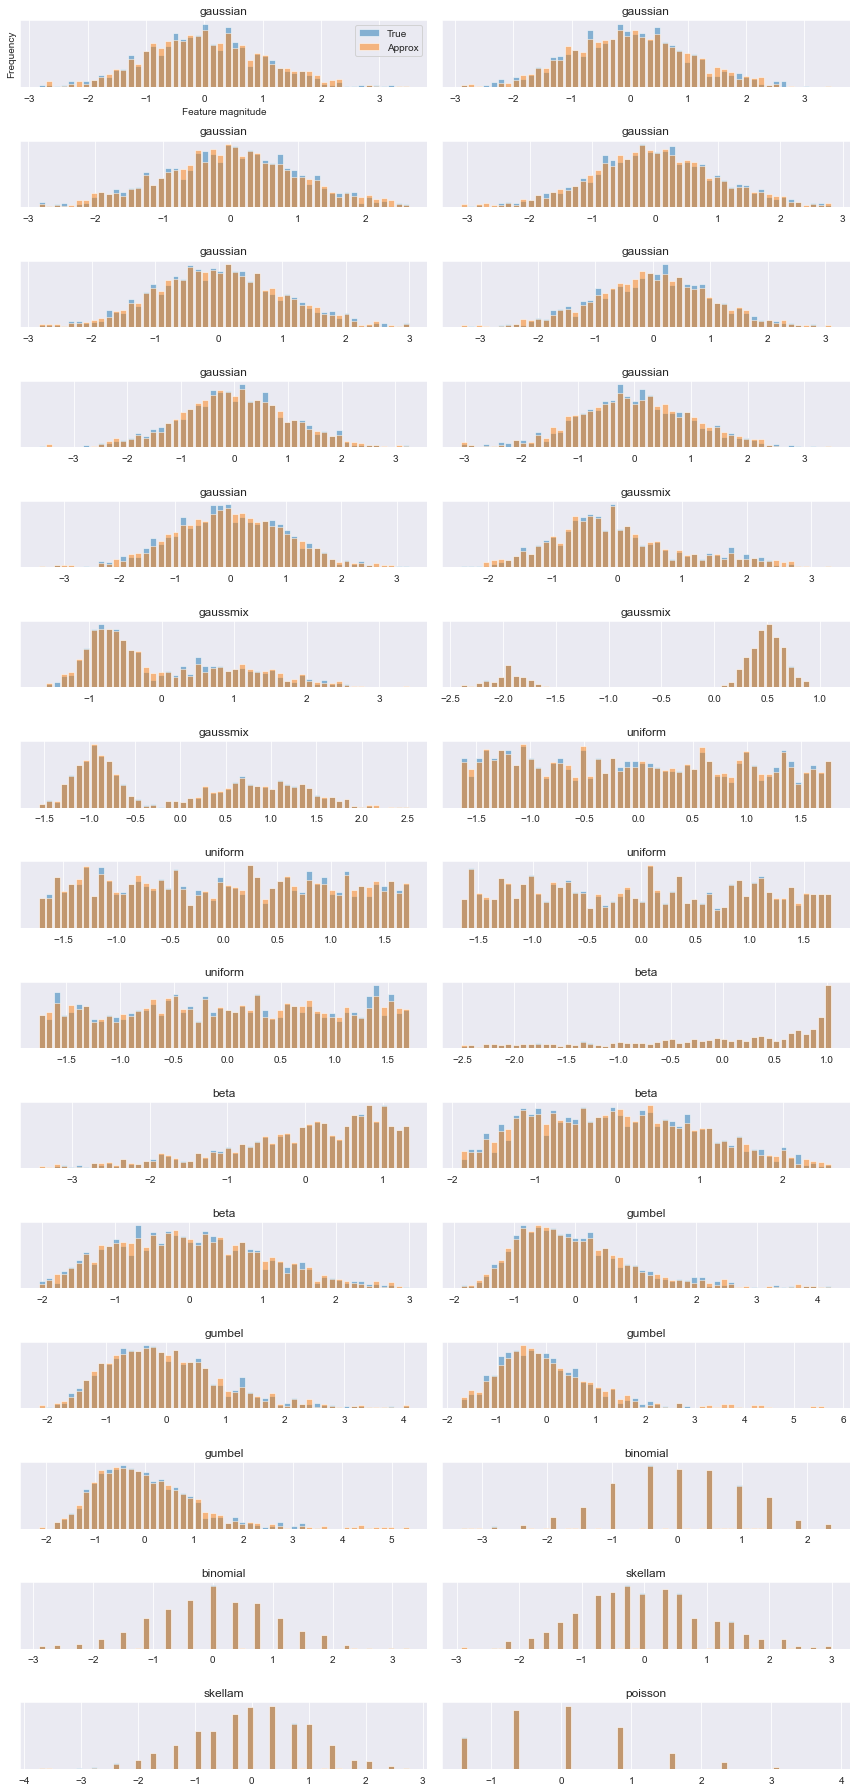

In [16]:
# also compare via plots
# plotting scaled structured data before and after pca approx
fig8, ax8 = plt.subplots(15, 2, figsize=(12,25))
ax = ax8.ravel()
for i in range(30):
    center = (epdf_bins[i][:-1] + epdf_bins[i][1:])/2.0
    width = (epdf_bins[i][1]-epdf_bins[i][0])*0.8
    ax[i].bar(center, x_s_epdf[:, i], alpha=0.5,width=width)
    ax[i].bar(center, x_s_approx[:, i], alpha=0.5,width=width)
    ax[i].set_title(single_sim.distribution_types[i])
    ax[i].set_yticks(())
ax[0].set_xlabel("Feature magnitude")
ax[0].set_ylabel("Frequency")
ax[0].legend(['True', 'Approx'], loc='best')
fig8.tight_layout()

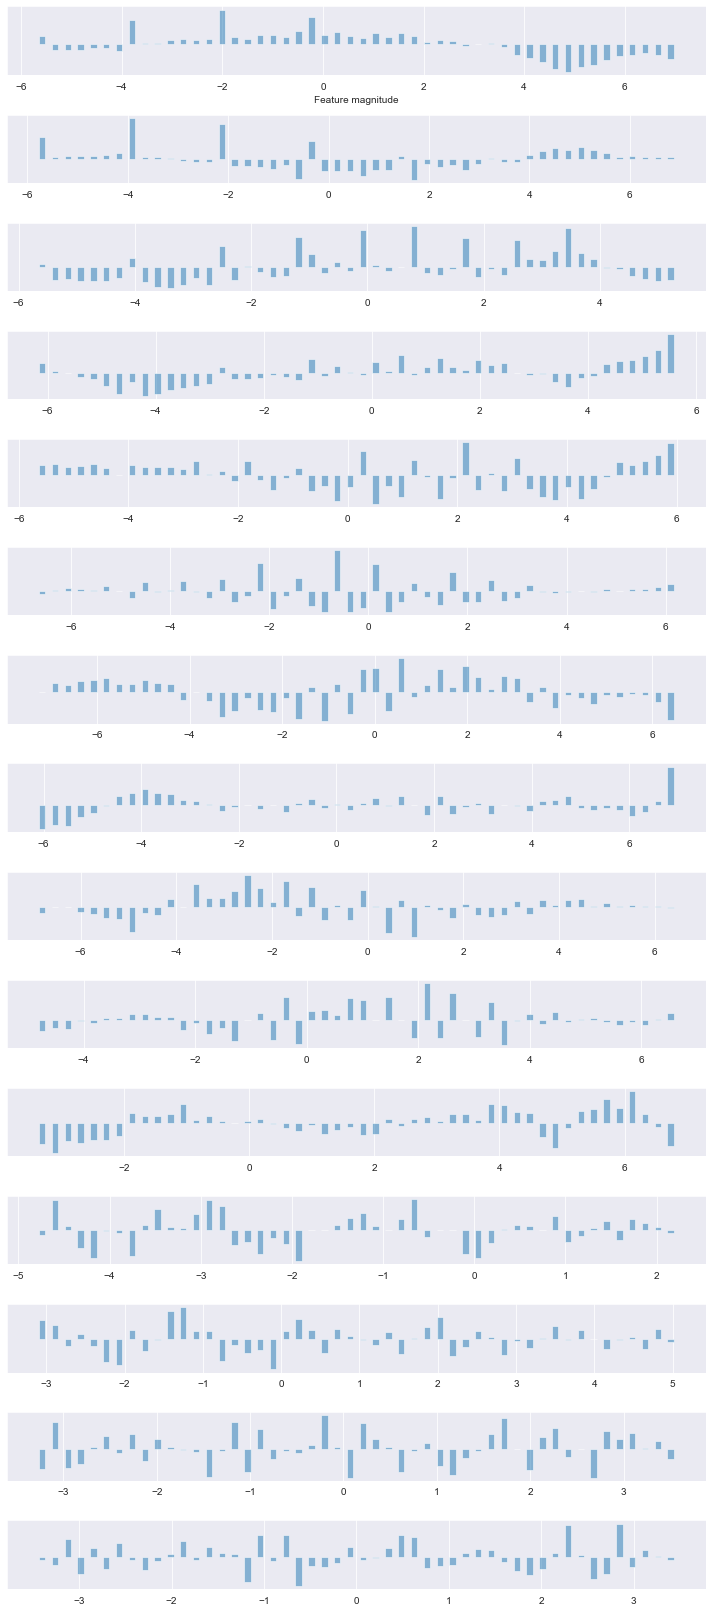

In [17]:
# visualizing the structured latent space
fig9, ax9 = plt.subplots(pca_s.n_components_, 1, figsize=(10,1.5*pca_s.n_components_))
ax = ax9.ravel()
# bar plot
for i in range(pca_s.n_components_):
    center = epdf_bins[i][:-1] + epdf_bins[i][1:]
    width = (epdf_bins[i][1]-epdf_bins[i][0])
    ax[i].bar(center, x_s_lat[:,i], alpha=0.5, width=width)
    ax[i].set_yticks(())
ax[0].set_xlabel("Feature magnitude")
fig9.tight_layout()

#### Tests for statistical consistency
In order to test the statistical consistency of the approximation, tests that operate on the samples and on the epdf probabilities are used (KS, JS, KL tests). This requires transformations between the statistical objects (empirical pdfs, empirical cdfs, and samples).

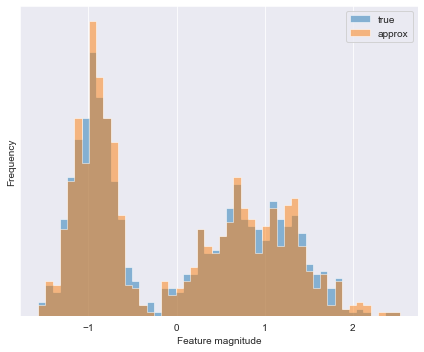

In [18]:
# generating pseudo-samples of approximated distributions with structured case

# for each epdf, create a dist object to sample from, then get num samples as from true samples
# working from: https://alpynepyano.github.io/healthyNumerics/posts/sampling_arbitrary_distributions_with_python.html
# generate ecdfs for each epdf approx
def ecdf_from_epdf(epdf_in, epdf_bins_in):
    """Generate an ecdf function based on an epdf"""
    ecdf = np.zeros_like(epdf_bins_in)
    ecdf[1:] = np.cumsum(epdf_in)
    ecdf = ecdf / ecdf[-1]
    return ecdf

# these are the y values of the ecdf, the x values are the epdf left bin edges
ecdf_approxs = []
for i in range(0,x_s_approx.shape[1]):
    ecdf_a = ecdf_from_epdf(x_s_approx[:,i],epdf_bins[i])
    ecdf_approxs.append(ecdf_a)
ecdf_approxs = np.array(ecdf_approxs)

# now use ecdfs to generate pseudo-samples from empirical pdfs
def get_epdf_sample(epdf_in, ecdf_in, epdf_bins_in):
    """Return a pseudo-sample from an epdf distribution"""
    # start from a random uniform sample
    ui = np.random.uniform(0.0,1.0)
    # get ecdf x and y index values around sample
    ind_hi = np.argmax(ecdf_in>=ui)
    ind_lo = np.argmax(ecdf_in>=ui)-1
    # get ecdf "y" values around ui
    x_hi = ecdf_in[ind_hi]
    x_lo = ecdf_in[ind_lo]
    # get ecdf "x" values around ui
    y_hi = epdf_bins_in[ind_hi]
    y_lo = epdf_bins_in[ind_lo]
    # fit linear model for continuous approx of ecdf "x" given ui as ecdf "y"
    slope = (y_hi-y_lo)/(x_hi-x_lo)
    intercept = y_hi - slope*x_hi
    sample = slope*ui + intercept
    return sample

# test sampling
samp_test = []
for i in range(0,1000):
    samp_test.append(get_epdf_sample(x_s_approx[:,12], ecdf_approxs[12],epdf_bins[12]))

# plot the test
fig11, ax11 = plt.subplots(1, 1, figsize=(6,5))
ax = ax11
_, bins = np.histogram(data_pca[:, 12], bins=50)
ax.hist(data_pca[:, 12], bins=bins, alpha=0.5, histtype='stepfilled',label="true")
ax.hist(np.array(samp_test), bins=bins, alpha=0.5, histtype='stepfilled',label="approx")
ax.set_yticks(())
ax.set_xlabel("Feature magnitude")
ax.set_ylabel("Frequency")
ax.legend()
fig11.tight_layout()

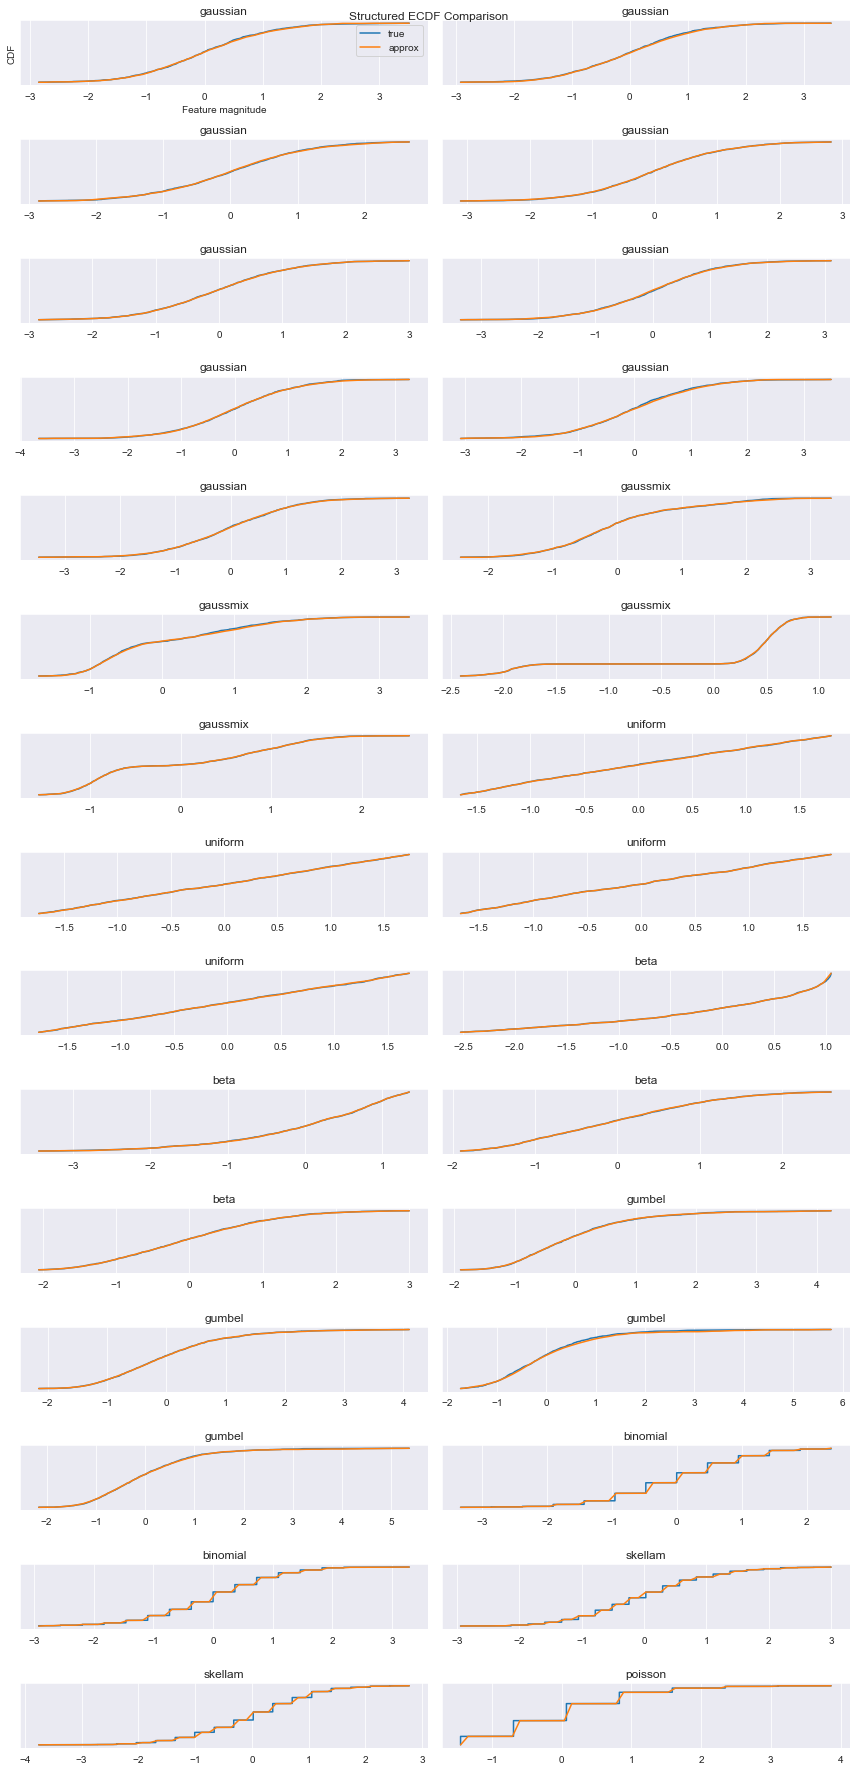

In [19]:
# approximate and true ecdf comparison
# plotting scaled data
fig13, ax13 = plt.subplots(15, 2, figsize=(12,25))
ax = ax13.ravel()
for i in range(30):
    ax[i].plot(x_t_ecdfs[i].x, x_t_ecdfs[i].y)
    ax[i].plot(epdf_bins[i], ecdf_approxs[i,:])
    ax[i].set_title(single_sim.distribution_types[i])
    ax[i].set_yticks(())
ax[0].set_xlabel("Feature magnitude")
ax[0].set_ylabel("CDF")
ax[0].legend(['true', 'approx'], loc='best')
fig13.suptitle('Structured ECDF Comparison')
fig13.tight_layout()

In [20]:
# generate sets of approximated samples from approximate distributions
approx_samples = []
for i in range(0,x_s_approx.shape[1]):
    inter_samples = []
    for j in range(0,1000):
        inter_samples.append(get_epdf_sample(x_s_approx[:,i], ecdf_approxs[i], epdf_bins[i]))
    approx_samples.append(np.array(inter_samples))
approx_samples = np.array(approx_samples).T

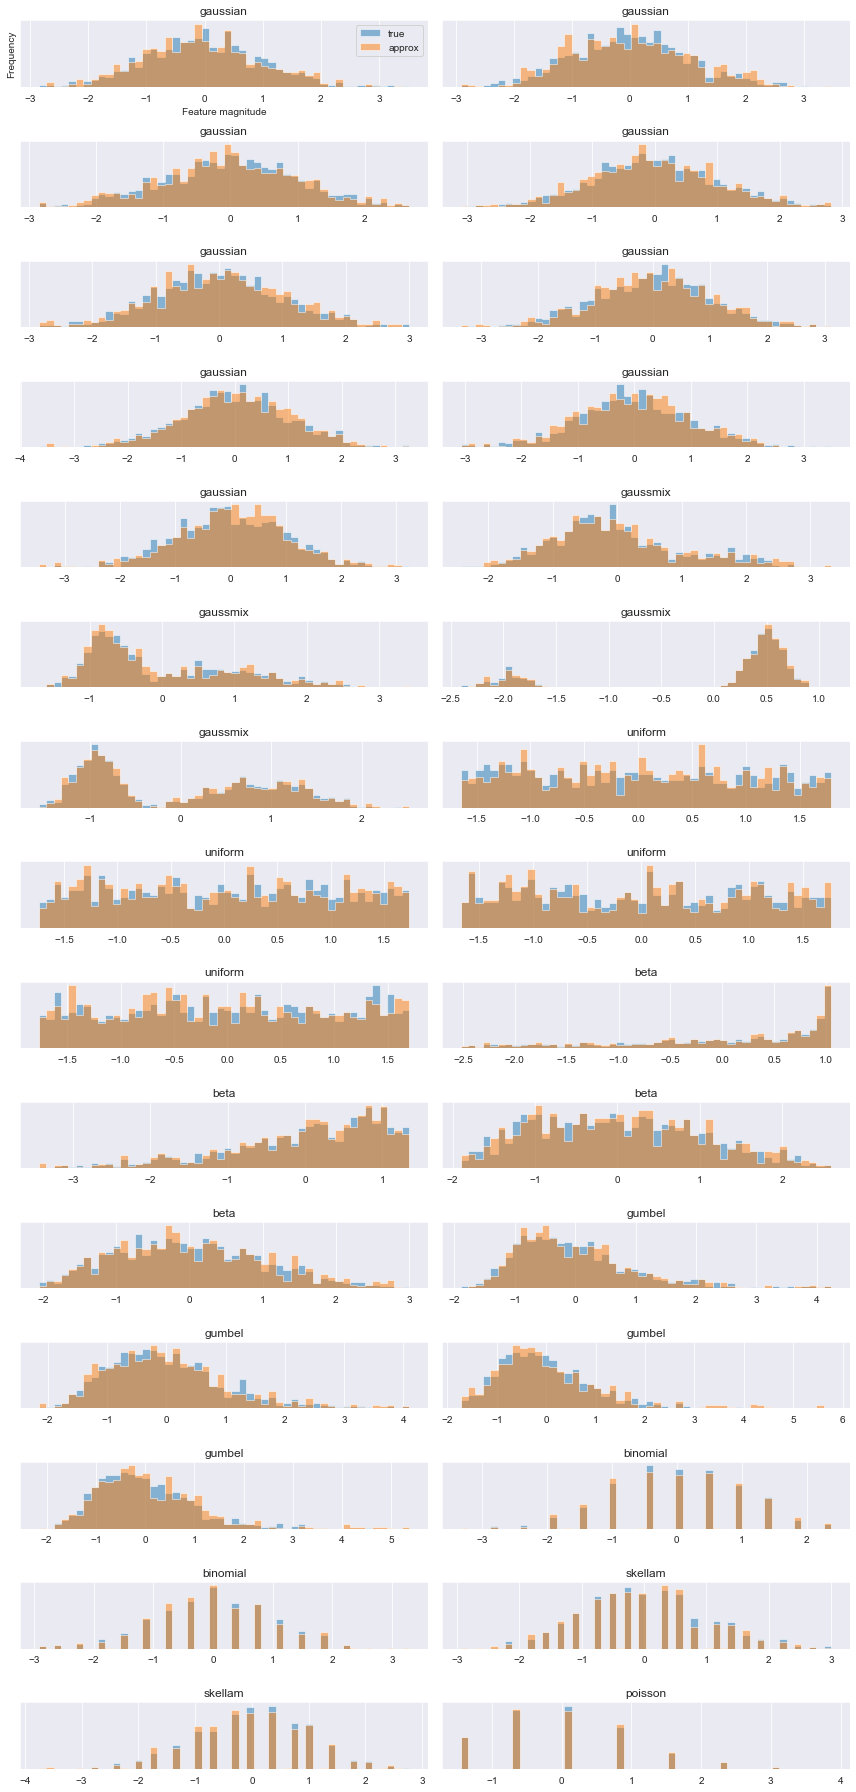

In [21]:
# compare samples from original distributions and approximate distributions
# take a look at plots of the samples (without scaling)
fig12, ax12 = plt.subplots(15, 2, figsize=(12,25))
ax = ax12.ravel()
for i in range(data_pca.shape[1]):
    _, bins = np.histogram(data_pca[:, i], bins=50)
    ax[i].hist(data_pca[:, i], bins=bins, alpha=0.5, histtype='stepfilled',label='true')
    ax[i].hist(approx_samples[:, i], bins=bins, alpha=0.5, histtype='stepfilled',label='approx')
    ax[i].set_title(single_sim.distribution_types[i])
    ax[i].set_yticks(())
ax[0].set_xlabel("Feature magnitude")
ax[0].set_ylabel("Frequency")
ax[0].legend()
fig12.tight_layout()

#### Calculating statistical consistency across dataset

In [22]:
# comparison of statistical distancing for structured and unstructured OR cases

# unstructured OR comparison between distributions
# initialize arrays for storage
ks_pval = []
ks_metr = []
js_dist = []
kl_divr = []
# make calculations
for i in range(0,len(x_t_ecdfs)):
    ks_m, ks_p = st.ks_2samp(x_true[:,i],x_approx[:,i])
    ks_pval.append(ks_p)
    ks_metr.append(ks_m)
    js_d = compute_js_dist(x_t_epdfs[i],x_a_epdfs[i])
    js_dist.append(js_d)
    kl_d = compute_kl_dist(x_t_epdfs[i],x_a_epdfs[i])
    kl_divr.append(kl_d)

In [23]:
# structured
ks_pval_s = []
ks_metr_s = []
js_dist_s = []
kl_divr_s = []
# make calculations
for i in range(0,x_s_approx.shape[1]):
    ks_m, ks_p = st.ks_2samp(x_true[:,i],approx_samples[:,i])
    ks_pval_s.append(ks_p)
    ks_metr_s.append(ks_m)
    js_d = compute_js_dist(x_t_epdfs[i],x_s_approx[:,i])
    js_dist_s.append(js_d)
    kl_d = compute_kl_dist(x_t_epdfs[i],x_s_approx[:,i])
    kl_divr_s.append(kl_d)

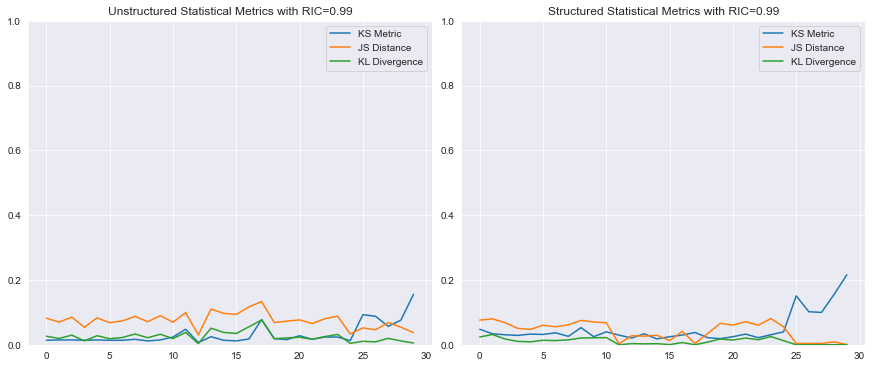

In [24]:
# plot
# plot the distance metrics
fig10, ax10 = plt.subplots(1,2,layout='constrained',figsize=(12,5))
ax = ax10.ravel()
ax[0].plot(range(0,x_true.shape[1]),ks_metr, label='KS Metric')
ax[0].plot(range(0,x_true.shape[1]),js_dist, label='JS Distance')
ax[0].plot(range(0,x_true.shape[1]),kl_divr, label='KL Divergence')
ax[0].set_ylim([0,1])
ax[0].legend()
ax[0].set_title('Unstructured Statistical Metrics with RIC='+str(req_ric))
ax[1].plot(range(0,x_true.shape[1]),ks_metr_s, label='KS Metric')
ax[1].plot(range(0,x_true.shape[1]),js_dist_s, label='JS Distance')
ax[1].plot(range(0,x_true.shape[1]),kl_divr_s, label='KL Divergence')
ax[1].set_ylim([0,1])
ax[1].set_title('Structured Statistical Metrics with RIC='+str(req_ric))
ax[1].legend()

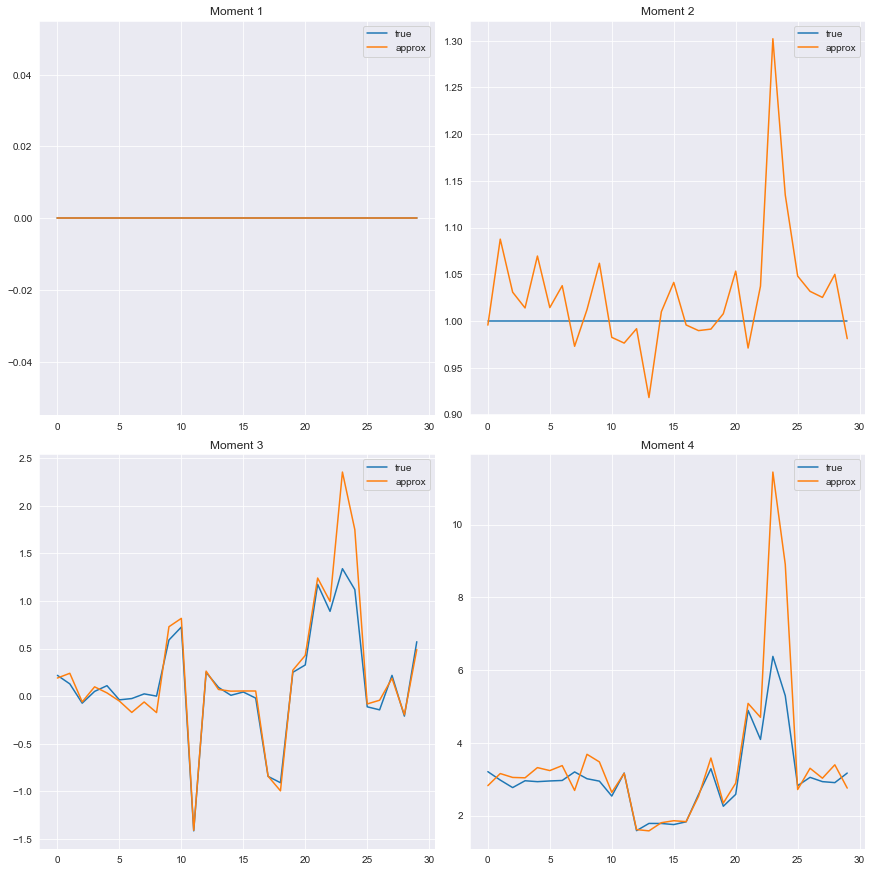

In [25]:
# comparison of moments, ranges, and quantiles before and after

moments = [1,2,3,4]

# true data and statistics
stats_data_true = data_pca
true_moments = st.moment(stats_data_true,moments,axis=0)

# approximate data and statistics
stats_data_aprx = approx_samples
aprx_moments = st.moment(stats_data_aprx, moments, axis=0)

# plot comparison
fig14, ax14 = plt.subplots(2,2,layout='constrained',figsize=(12,12))
ax = ax14.ravel()
for i in range(ax.shape[0]):
    ax[i].plot(range(0,true_moments.shape[1]),true_moments[i,:],label='true')
    ax[i].plot(range(0,aprx_moments.shape[1]),aprx_moments[i,:],label='approx')
    ax[i].legend()
    ax[i].set_title('Moment '+str(i+1))

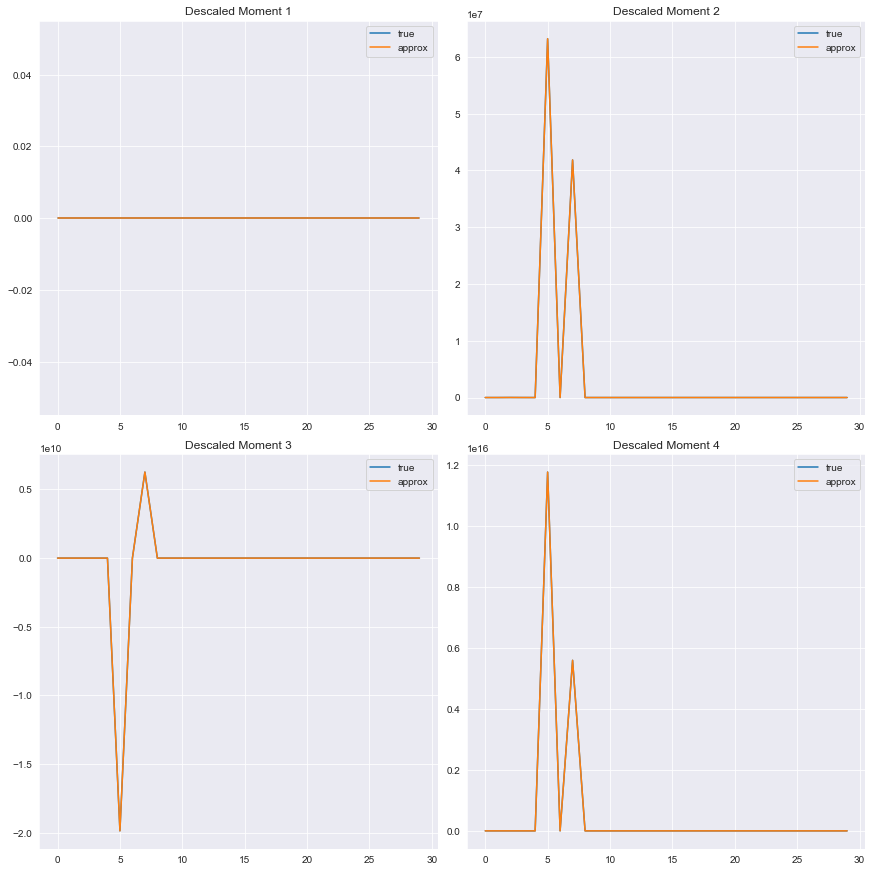

In [26]:
# comparison of de-scaled true and approximate data

# de-scaling the data
descaled_true = data.scaler.inverse_transform(stats_data_true)
descaled_aprx = data.scaler.inverse_transform(stats_data_aprx)

# moments
ds_true_moments = st.moment(descaled_true,moments,axis=0)
ds_aprx_moments = st.moment(descaled_aprx,moments,axis=0)

# moment percent error? range? quantiles?

# plot comparison
fig15, ax15 = plt.subplots(2,2,layout='constrained',figsize=(12,12))
ax = ax15.ravel()
for i in range(ax.shape[0]):
    ax[i].plot(range(0,ds_true_moments.shape[1]),ds_true_moments[i,:],label='true')
    ax[i].plot(range(0,ds_aprx_moments.shape[1]),ds_true_moments[i,:],label='approx')
    ax[i].legend()
    ax[i].set_title('Descaled Moment '+str(i+1))

#### Results of statistical consistency test
These initial results show reasonably close agreement of the statistical distributions - the true samples and the approximation. There is some deviation, especially with the discrete distributions - this will be addressed with a discretization step in the following notebooks.

Finally, for this notebook, the descaled distributions are compared below to finish out the approximation.

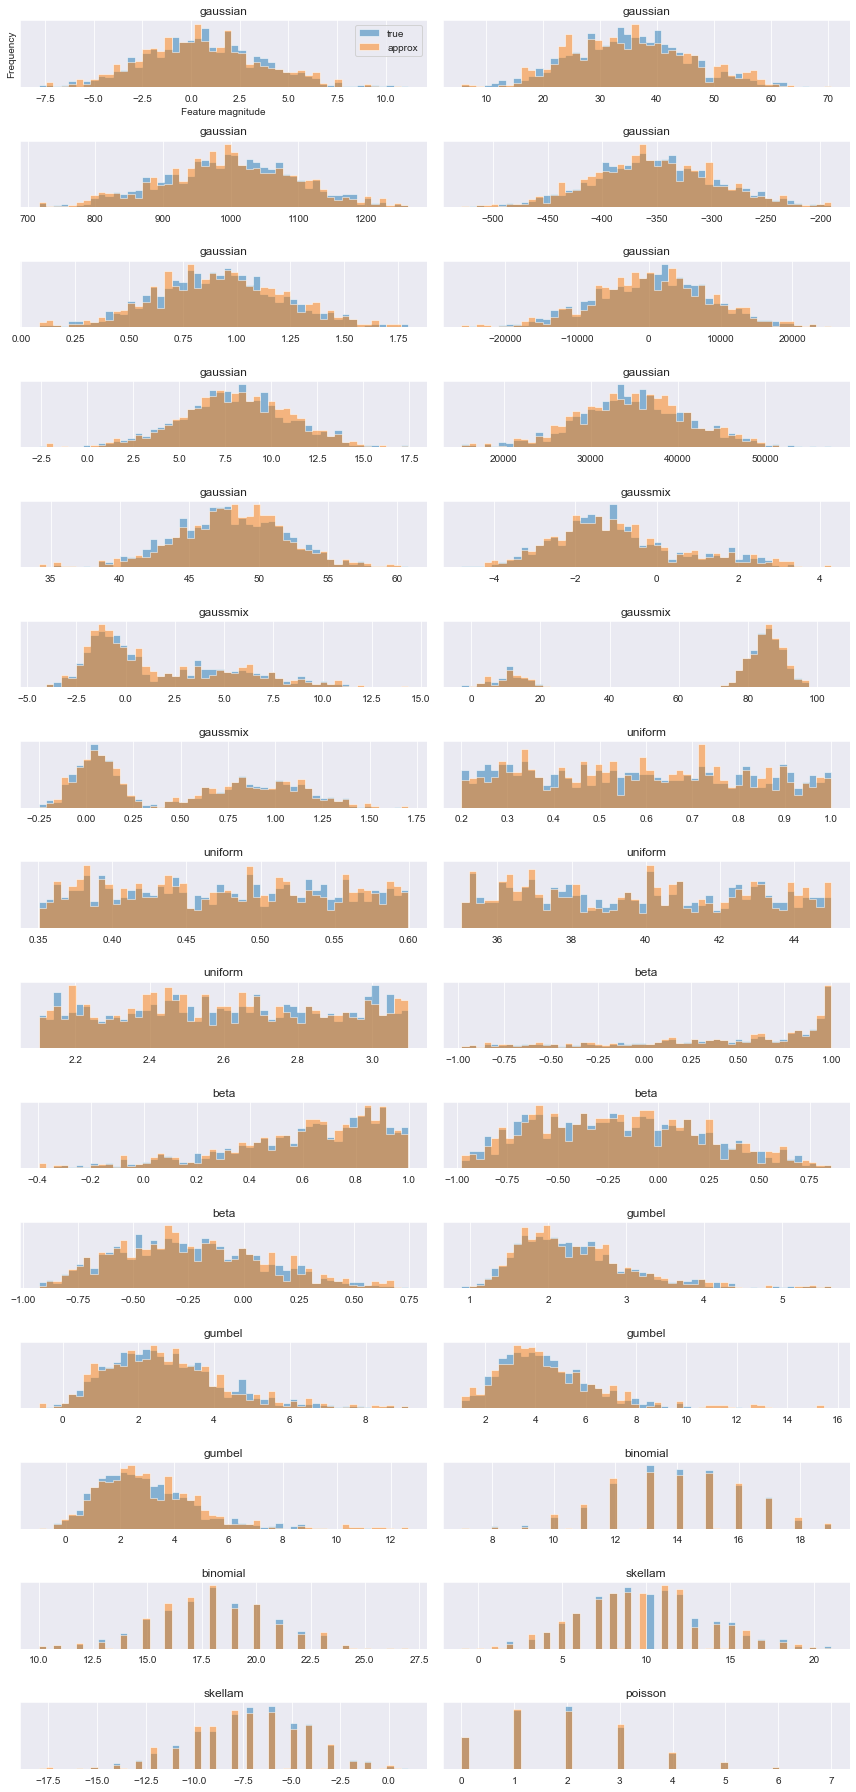

In [27]:
# comparison of de-scaled true and approximate data

# plotted histograms
fig16, ax16 = plt.subplots(15, 2, figsize=(12,25))
ax = ax16.ravel()
for i in range(data_pca.shape[1]):
    _, bins = np.histogram(descaled_true[:, i], bins=50)
    ax[i].hist(descaled_true[:, i], bins=bins, alpha=0.5, histtype='stepfilled',label='true')
    ax[i].hist(descaled_aprx[:, i], bins=bins, alpha=0.5, histtype='stepfilled',label='approx')
    ax[i].set_title(single_sim.distribution_types[i])
    ax[i].set_yticks(())
ax[0].set_xlabel("Feature magnitude")
ax[0].set_ylabel("Frequency")
ax[0].legend()
fig16.tight_layout()